# Homework 1 - Fashion-MNIST (MLP)

## Define constants, functions and set random seed

In [1]:
IMAGE_SIZE = 28 * 28
LABEL_COUNT = 10
SEED = 0xFFFF

from matplotlib import pyplot
from keras import callbacks
def show_train_history(history: callbacks.History, result: str, validation: str):
    pyplot.plot(history.history[result])
    pyplot.plot(history.history[validation])
    pyplot.title("Model " + result)
    pyplot.ylabel(result)
    pyplot.xlabel("epoch")
    pyplot.legend(["result", "validation"], loc="upper left")
    pyplot.show()

import os
from datetime import datetime
def create_result_dir() -> str:
    result_dir = "result." + datetime.today().strftime("%y%m%d-%H%M%S")
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    else:
        result_dir_suffix = 0
        while os.path.exists(result_dir + "-" + str(result_dir_suffix)):
            result_dir_suffix += 1
        result_dir = result_dir + "-" + str(result_dir_suffix)
        os.makedirs(result_dir)
    return result_dir

import numpy
numpy.random.seed(SEED)

Using plaidml.keras.backend backend.


## Read and prepare data

In [2]:
import zipfile, pandas
from keras.utils import np_utils
# Github has 100MB limited of each file, so I zipped it.
# train = pandas.read_csv("data/train_data.csv")
train_zip = zipfile.ZipFile("data/train_data.zip")
train = pandas.read_csv(train_zip.open("train_data.csv"))
test = pandas.read_csv("data/test_data.csv")
train_labels = np_utils.to_categorical(train["label"])
train_images = train.iloc[:, 1:].values.astype("float32") / 0xFF
test_images = test.values.astype("float32") / 0xFF

## Create a model

In [3]:
from keras import models, layers, initializers, activations, regularizers
model = models.Sequential([
    layers.Dense(
        units=1600,
        activation=activations.relu,
        kernel_initializer=initializers.glorot_uniform(seed=SEED),
        # kernel_regularizer=regularizers.l2(0.002),
        input_dim=IMAGE_SIZE,
    ),
    layers.Dropout(0.64),
    layers.Dense(
        units=1200,
        activation=activations.relu,
        kernel_initializer=initializers.glorot_uniform(seed=SEED),
        # kernel_regularizer=regularizers.l2(0.),
    ),
    layers.Dropout(0.8),
    layers.Dense(
        units=LABEL_COUNT,
        activation=activations.softmax,
        kernel_initializer=initializers.glorot_normal(seed=SEED),
    ),
])

from keras import optimizers, losses
model.compile(
    optimizer=optimizers.Adam(
        decay=0.0012,
        amsgrad=True,
    ),
    loss=losses.categorical_crossentropy,
    metrics=["accuracy"],
)

model.summary()

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1600)              1256000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1200)              1921200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                12010     
Total params: 3,189,210
Trainable params: 3,189,210
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [4]:
from os import path
result_dir = create_result_dir()
model_path = path.join(result_dir, "model.hdf5")

# Scores in Kaggle Public Leaderboard
# 0.90800: epochs=80,    save_best_only=False, backend=plaidml.keras.backend(GPU,OpenCL)
# 0.90900: epochs=80,    save_best_only=False, backend=tensorflow(CPU)
# 0.91533: epochs=12000, save_best_only=True,  backend=plaidml.keras.backend(GPU,OpenCL)

from keras import callbacks
model_checkpoint = callbacks.ModelCheckpoint(
    model_path,
    monitor="val_acc",
    verbose=1,
    # save_best_only=True,
)
# early_stopping = callbacks.EarlyStopping(
#     monitor="val_acc",
#     patience=20,
#     verbose=1,
#     restore_best_weights=True,
# )

history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=4000,
    epochs=80,
    verbose=2,
    callbacks=[
        model_checkpoint,
        # early_stopping,
    ], 
    validation_split=0.2,
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/80
 - 10s - loss: 1.2599 - acc: 0.5493 - val_loss: 0.6395 - val_acc: 0.7676

Epoch 00001: saving model to result.181031-132141\model.hdf5
Epoch 2/80
 - 2s - loss: 0.6683 - acc: 0.7588 - val_loss: 0.5201 - val_acc: 0.8132

Epoch 00002: saving model to result.181031-132141\model.hdf5
Epoch 3/80
 - 4s - loss: 0.5512 - acc: 0.8034 - val_loss: 0.4622 - val_acc: 0.8342

Epoch 00003: saving model to result.181031-132141\model.hdf5
Epoch 4/80
 - 4s - loss: 0.4974 - acc: 0.8246 - val_loss: 0.4245 - val_acc: 0.8538

Epoch 00004: saving model to result.181031-132141\model.hdf5
Epoch 5/80
 - 4s - loss: 0.4615 - acc: 0.8357 - val_loss: 0.4013 - val_acc: 0.8590

Epoch 00005: saving model to result.181031-132141\model.hdf5
Epoch 6/80
 - 4s - loss: 0.4412 - acc: 0.8420 - val_loss: 0.3854 - val_acc: 0.8626

Epoch 00006: saving model to result.181031-132141\model.hdf5
Epoch 7/80
 - 2s - loss: 0.4156 - acc: 0.8523 - val_loss: 0.3731 - val_acc: 0.8

# Show training result and save predictions.

In [5]:
model = models.load_model(model_path)
predictions = model.predict_classes(test_images)
pandas.DataFrame(
    data={
        "id": numpy.array(range(1, predictions.size + 1)),
        "label": predictions,
    },
).to_csv(
    path.join(result_dir, "predictions.csv"),
    index=False,
)

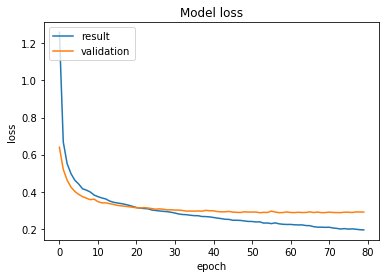

In [6]:
show_train_history(history, "loss", "val_loss")

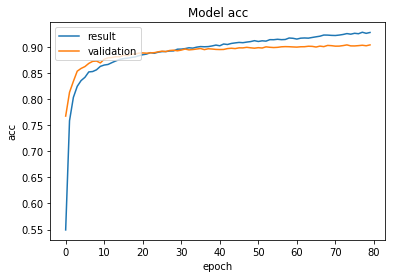

In [7]:
show_train_history(history, "acc", "val_acc")